In [1]:
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *

In [106]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/all_subreddits.csv')

## Preprocessing

In [128]:
import re #regex library used for substituting words
import demoji #https://github.com/bsolomon1124/demoji
demoji.download_codes()

/var/folders/q6/mkn146812pz0n3cx40bgg__40000gn/T/ipykernel_96566/2700635268.py:3: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [129]:
def pre_cleaning(text):
    line=re.sub(r"\Bu/\w+", "USERNAME", text) #replace username with USERNAME
    line = demoji.replace(line, repl=' ')
    return line

In [130]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [131]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [132]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [133]:
df.body = df.body.apply(lambda x: preprocessing(x))

In [134]:
df.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,carmen legge northville farm centerville nova scotia scott doug went visit week episode think carmen northville farm time someone fellowship dig visited season could temporarily relocated due covid restrictions,0.0000
1,13261673,ukpolitics,1597987216,need expert see boris covid brexit fall guy,0.0000
2,261403,amazonfc,1634437900,made month lol worked amazon covid hit whole family got covid really go anymore lol rejoined,0.7818
3,15681814,drugs,1590316428,looks like discussing thing contact medical emergency government services country concerns seconds find whats important crew scot made awesome infographic american society addiction medicine dedicated page site contains news guidance resources around country regarding addiction treatment wake covid national institute drug abuse covid potential implications individuals substance use disorders us state may request blanket exceptions stable patients opioid treatment program receive days take home doses patient medication opioid use disorder want discuss covid leave comment official weekly fre...,0.8391
4,3153614,politics,1628274205,gt decent covid response yes killing states economy snd longest lockdowns great response california gdp saw roughly 8 drop florida saw drop california kill economy economy quite well things considering trade california roughly higher survival rate 8 economic loss seems like decent trade plus number likely go considering fact 6x many floridians currently dying covid compared californians,0.7289


In [159]:
sample = df.sample(5000)

Text(0.5, 1.0, 'Sentiment Data Distribution')

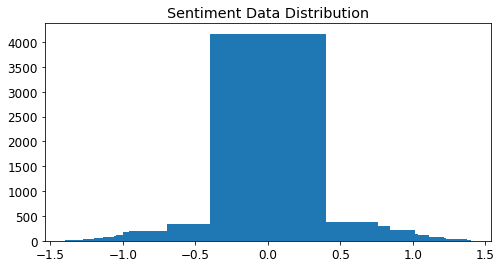

In [125]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [29]:
from sklearn.model_selection import train_test_split

In [160]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 4000
Test Data size 1000


## Model

In [52]:
lb=LabelEncoder()
sample['sentiment'] = lb.fit_transform(sample['sentiment'])

In [161]:
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

In [152]:
X.shape

(50000, 300)

In [163]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(sample['body'].values)
X = tokenizer.texts_to_sequences(sample['body'].values)
X = pad_sequences(X, maxlen = 300)

In [177]:
y = sample['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [165]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'MeanSquaredError', optimizer='adam', metrics = ['MeanSquaredError'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 120)          60000     
                                                                 
 spatial_dropout1d_8 (Spatia  (None, 300, 120)         0         
 lDropout1D)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 176)               209088    
                                                                 
 dense_12 (Dense)            (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [178]:
batch_size=32
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
125/125 [==============================] - 86s 638ms/step - loss: nan - mean_squared_error: nan
Epoch 2/5
125/125 [==============================] - 96s 770ms/step - loss: nan - mean_squared_error: nan
Epoch 3/5
125/125 [==============================] - 93s 742ms/step - loss: nan - mean_squared_error: nan
Epoch 4/5
125/125 [==============================] - 90s 721ms/step - loss: nan - mean_squared_error: nan
Epoch 5/5
125/125 [==============================] - 92s 737ms/step - loss: nan - mean_squared_error: nan


In [179]:
model.evaluate(X_test,y_test)

32/32 [==============================] - 3s 78ms/step - loss: nan - mean_squared_error: nan


[nan, nan]

In [157]:
bs = 64
cut = int(50000 * 0.8)
dls = DataLoaders.from_dsets(train_data, test_data, bs=64, shuffle=False)

In [36]:
class LModel(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [39]:
vocab = vectorizer.get_feature_names()

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [141]:
import torch

In [158]:
learn = Learner(dls, LModel(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastai/data/load.py", line 118, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastcore/basics.py", line 217, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastai/data/load.py", line 133, in do_item
    try: return self.after_item(self.create_item(s))
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastai/data/load.py", line 140, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 3458, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
    raise KeyError(key) from err
KeyError: 0
